# **ASHRAE CHALLENGE**

## **1.Importing required Libaries**

In [0]:
import pandas as pd
import gc
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **2.Getting The Data From Kaggle**

In [0]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [8]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rahmaakaichi","key":"40919b3a47db3dc3d7bdf1788454678e"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [10]:
!kaggle competitions download -c ashrae-energy-prediction

 99% 165M/167M [00:01<00:00, 63.8MB/s]
100% 167M/167M [00:01<00:00, 91.2MB/s]
  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 170MB/s]
 94% 83.0M/88.4M [00:01<00:00, 70.6MB/s]
100% 88.4M/88.4M [00:01<00:00, 76.1MB/s]
  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 39.4MB/s]
  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 176MB/s]
 86% 103M/120M [00:02<00:00, 40.5MB/s] 
100% 120M/120M [00:02<00:00, 54.1MB/s]


In [0]:
train_df = pd.read_csv('/content/train.csv.zip',compression = 'infer')
weather_train_df = pd.read_csv('/content/weather_train.csv.zip',compression = 'infer')
build_metadata_df = pd.read_csv('/content/building_metadata.csv',compression = 'infer')


In [12]:
train_df.shape

(20216100, 4)

In [13]:
build_metadata_df.shape

(1449, 6)

In [14]:
weather_train_df.shape

(139773, 9)

In [15]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [16]:
build_metadata_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [0]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


### **3.Counting null values**

In [17]:
weather_train_df.isnull().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

In [0]:
train_df.isnull().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

In [0]:
build_metadata_df.isnull().sum()

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

## **4.Merging Data**

In [0]:
train_data = train_df.merge(build_metadata_df, on="building_id", how="left")

In [0]:
train_data = train_data.merge(weather_train_df, on=["site_id","timestamp"])


In [20]:
train_data.isnull().sum()

building_id                  0
meter                        0
timestamp                    0
meter_reading                0
site_id                      0
primary_use                  0
square_feet                  0
year_built            12113306
floor_count           16630052
air_temperature           6163
cloud_coverage         8734870
dew_temperature           9645
precip_depth_1_hr      3658528
sea_level_pressure     1141174
wind_direction         1358553
wind_speed               53181
dtype: int64

In [21]:
train_data.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


### **4.1Removing Outliers**

In [0]:
train_data.loc[train_data['meter_reading']>6400,'meter_reading'] = 6400
train_data.loc[train_data['air_temperature']<-22,'air_temperature']=-22
train_data.loc[train_data['air_temperature']>48,'air_temperature']=48
train_data.loc[train_data['dew_temperature']<-30,'dew_temperature']=-30
train_data.loc[train_data['sea_level_pressure']<993,'sea_level_pressure']=993
train_data.loc[train_data['sea_level_pressure']>1040,'sea_level_pressure']=1040
train_data.loc[train_data['wind_speed']>12.7,'wind_speed']=12.7
#train_data.loc[train_data['square_feet']>800000,'square_feet']=800000
train_data.loc[train_data['precip_depth_1_hr']>40,'precip_depth_1_hr'] = 40
train_data.loc[train_data['floor_count']>19,'floor_count']=19

### **4.2 Plotting Distributions of the data**

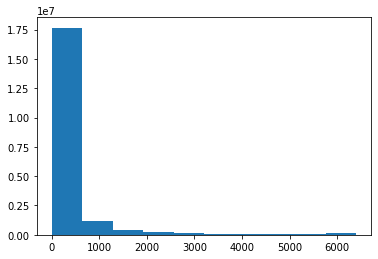

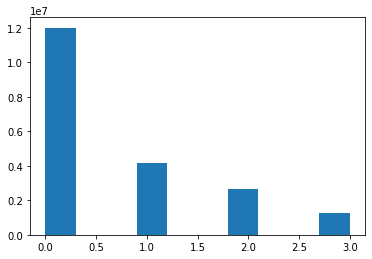

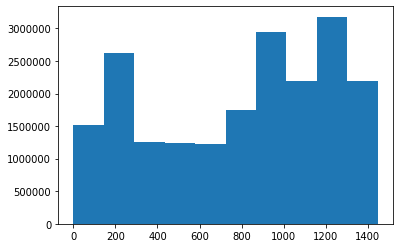

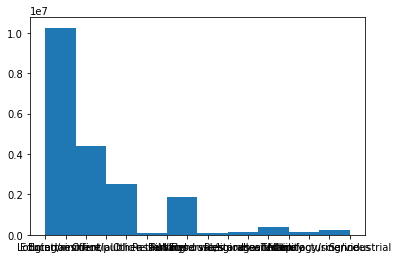

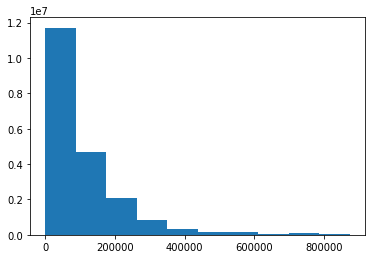

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


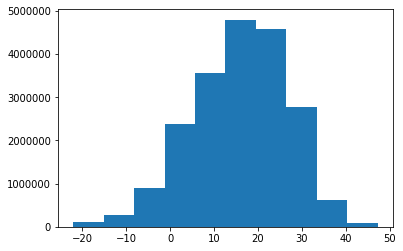

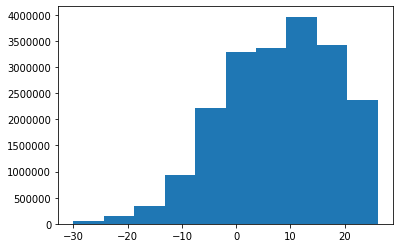

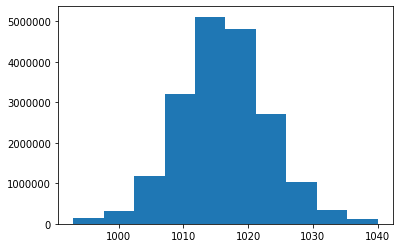

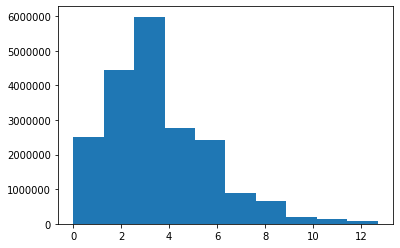

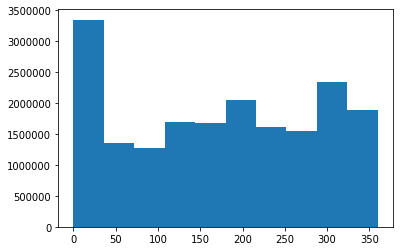

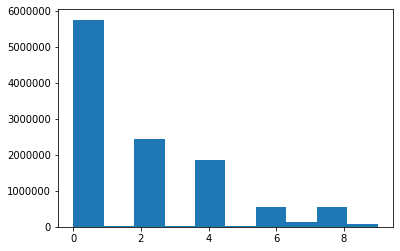

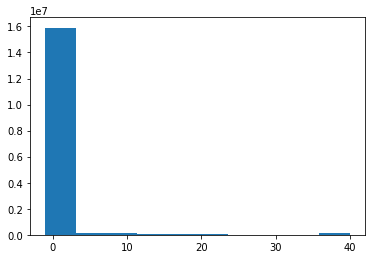

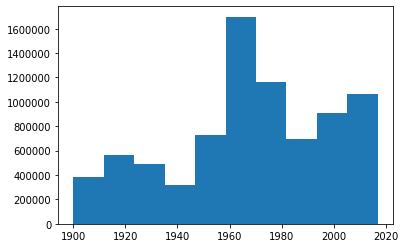

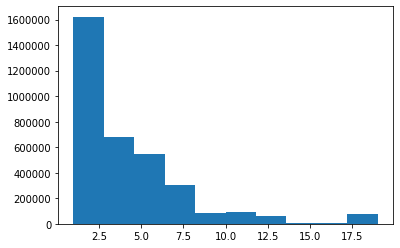

In [10]:

plt.hist(train_data['meter_reading'])
plt.show()                             
plt.hist(train_data['meter'])
plt.show()
plt.hist(train_data['building_id'])
plt.show()
plt.hist(train_data['primary_use'])
plt.show()
plt.hist(train_data['square_feet'])
plt.show()
plt.hist(train_data['air_temperature'])
plt.show()
plt.hist(train_data['dew_temperature'])
plt.show()
plt.hist(train_data['sea_level_pressure'])
plt.show()
plt.hist(train_data['wind_speed'])
plt.show()
plt.hist(train_data['wind_direction'])
plt.show()
plt.hist(train_data['cloud_coverage'])
plt.show()
plt.hist(train_data['precip_depth_1_hr'])
plt.show()
plt.hist(train_data['year_built'])
plt.show()
plt.hist(train_data['floor_count'])
plt.show()


### **4.3Converting to Pandas Datetimeformat**

In [0]:
holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                "2017-01-02", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                "2019-01-01"]

In [0]:
train_data.timestamp = pd.to_datetime(train_data.timestamp, format="%Y-%m-%d %H:%M:%S")
  
train_data["hour"] = train_data.timestamp.dt.hour
train_data["month"]= train_data.timestamp.dt.month
train_data["weekday"] = train_data.timestamp.dt.weekday
train_data["is_holiday"] = (train_data.timestamp.isin(holidays)).astype(int)

In [13]:
train_data.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,month,weekday,is_holiday
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1


### **4.4Removing irrelivant data**

In [0]:
train_data.drop(['timestamp'],axis=1,inplace = True)

### **4.5 Displaying Correlated variables**

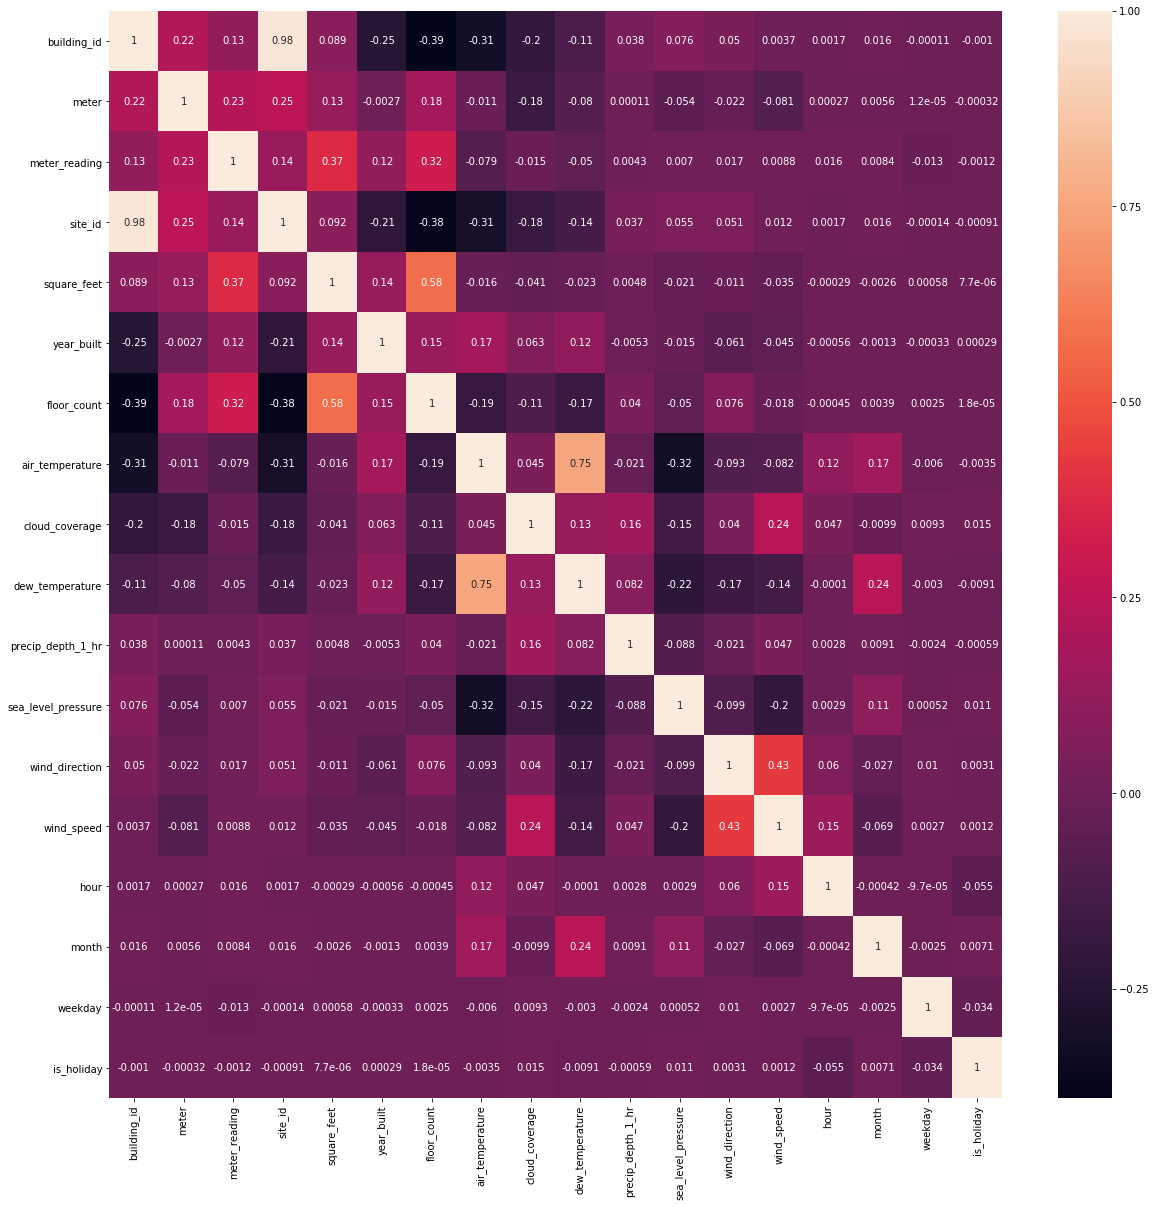

In [28]:
correlation = train_data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation,annot=True)

In [29]:
train_data.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,month,weekday,is_holiday
0,0,0,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1
1,1,0,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1
2,2,0,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1
3,3,0,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1
4,4,0,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1


### **4.6 Normalizing the Data**

In [30]:
train_data.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,month,weekday,is_holiday
0,0,0,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1
1,1,0,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1
2,2,0,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1
3,3,0,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1
4,4,0,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1


In [0]:
p1 = train_data['building_id']*train_data['meter']
p2 = train_data['square_feet']/train_data['sea_level_pressure']
p3 = train_data['air_temperature']+train_data['dew_temperature']
p5 = train_data['site_id']
p6 = train_data['meter_reading']

In [16]:
df = pd.concat([p1,p2,p3,p5,p6,train_data['meter_reading']],axis = 1)
del p1,p2,p3,p5,p6
gc.collect()

6337

In [33]:
df.head()

,0,1,2,site_id,meter_reading,meter_reading
0,0,7.288418,45.0,0,0.0,0.0
1,0,2.667451,45.0,0,0.0,0.0
2,0,5.272139,45.0,0,0.0,0.0
3,0,23.227420,45.0,0,0.0,0.0
4,0,114.354222,45.0,0,0.0,0.0


In [17]:
df = df.iloc[:,:-1]
df.head()

,0,1,2,site_id,meter_reading
0,0,7.288418,45.0,0,0.0
1,0,2.667451,45.0,0,0.0
2,0,5.272139,45.0,0,0.0
3,0,23.227420,45.0,0,0.0
4,0,114.354222,45.0,0,0.0


In [0]:
pf = train_data
tf = df

In [0]:
pf.drop(['site_id','meter_reading'],axis=1,inplace = True)
pf = pd.concat([pf,tf],axis = 1)

In [37]:
pf.head()

,building_id,meter,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,month,weekday,is_holiday,0,1,2,site_id,meter_reading
0,0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1,0,7.288418,45.0,0,0.0
1,1,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1,0,2.667451,45.0,0,0.0
2,2,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1,0,5.272139,45.0,0,0.0
3,3,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1,0,23.227420,45.0,0,0.0
4,4,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1,0,114.354222,45.0,0,0.0


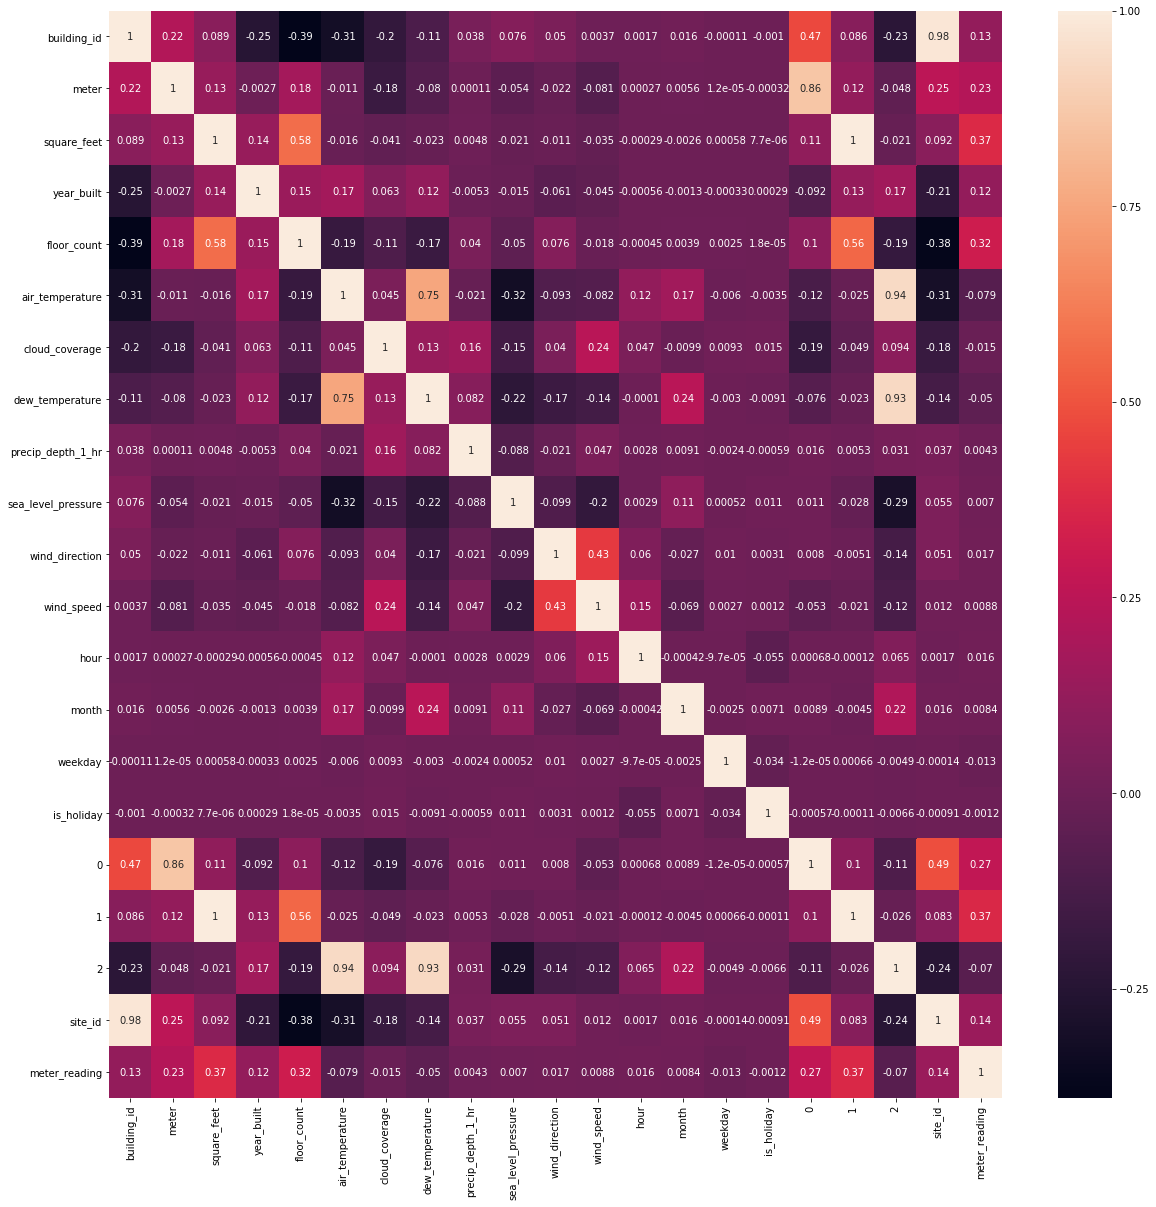

In [38]:
correlation = pf.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation,annot=True)

In [0]:
le = LabelEncoder()
pf['primary_use'] = le.fit_transform(pf['primary_use'])


### **5. Train and test split**

In [0]:
X = pf.iloc[:,:-1]
y = pf.iloc[:,-1]



In [41]:
X.head()

,building_id,meter,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,month,weekday,is_holiday,0,1,2,site_id
0,0,0,0,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1,0,7.288418,45.0,0
1,1,0,0,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1,0,2.667451,45.0,0
2,2,0,0,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1,0,5.272139,45.0,0
3,3,0,0,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1,0,23.227420,45.0,0
4,4,0,0,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1,0,114.354222,45.0,0


In [39]:
X.columns

Index([       'building_id',              'meter',        'primary_use',
              'square_feet',         'year_built',        'floor_count',
          'air_temperature',     'cloud_coverage',    'dew_temperature',
        'precip_depth_1_hr', 'sea_level_pressure',     'wind_direction',
               'wind_speed',               'hour',              'month',
                  'weekday',         'is_holiday',                    0,
                          1,                    2,            'site_id'],
      dtype='object')

In [44]:
y.tail()

20125600      8.750
20125601      4.825
20125602      0.000
20125603    159.575
20125604      2.850
Name: meter_reading, dtype: float64

In [47]:
X.shape

(20125605, 21)

In [0]:
tempo = X.copy()

In [0]:
tempo['meter_reading'] = y

In [51]:
tempo.shape

(20125605, 22)

In [52]:
tempo.columns

Index([       'building_id',              'meter',        'primary_use',
              'square_feet',         'year_built',        'floor_count',
          'air_temperature',     'cloud_coverage',    'dew_temperature',
        'precip_depth_1_hr', 'sea_level_pressure',     'wind_direction',
               'wind_speed',               'hour',              'month',
                  'weekday',         'is_holiday',                    0,
                          1,                    2,            'site_id',
            'meter_reading'],
      dtype='object')

In [43]:
tempo.tail()

,0,1,2,air_temperature,building_id,cloud_coverage,dew_temperature,floor_count,hour,is_holiday,meter,month,precip_depth_1_hr,primary_use,sea_level_pressure,site_id,square_feet,weekday,wind_direction,wind_speed,year_built
20124075,0.0,302.032360,16.1,12.8,651.0,2.0,3.3,5.0,23.0,0.0,0.0,12.0,0.0,8.0,1013.6,4.0,306140.0,5.0,30.0,2.1,2007.0
20124076,0.0,148.862470,16.1,12.8,652.0,2.0,3.3,9.0,23.0,0.0,0.0,12.0,0.0,0.0,1013.6,4.0,150887.0,5.0,30.0,2.1,1959.0
20124077,0.0,415.237766,16.1,12.8,653.0,2.0,3.3,8.0,23.0,0.0,0.0,12.0,0.0,0.0,1013.6,4.0,420885.0,5.0,30.0,2.1,1930.0
20124078,0.0,43.320837,16.1,12.8,654.0,2.0,3.3,5.0,23.0,0.0,0.0,12.0,0.0,0.0,1013.6,4.0,43910.0,5.0,30.0,2.1,1912.0
20124079,0.0,219.449487,16.1,12.8,655.0,2.0,3.3,11.0,23.0,0.0,0.0,12.0,0.0,0.0,1013.6,4.0,222434.0,5.0,30.0,2.1,1964.0


In [53]:
m = int(tempo.shape[0] / 2)
m

10062802

In [54]:
tempo.iloc[:m].isnull().any() 

building_id           False
meter                 False
primary_use           False
square_feet           False
year_built             True
floor_count            True
air_temperature        True
cloud_coverage         True
dew_temperature        True
precip_depth_1_hr      True
sea_level_pressure     True
wind_direction         True
wind_speed             True
hour                  False
month                 False
weekday               False
is_holiday            False
0                     False
1                      True
2                      True
site_id               False
meter_reading         False
dtype: bool

In [0]:
tempo = tempo[np.isfinite(tempo['year_built'])]
tempo = tempo[np.isfinite(tempo['floor_count'])]
tempo = tempo[np.isfinite(tempo['air_temperature'])]
tempo = tempo[np.isfinite(tempo['cloud_coverage'])]
tempo = tempo[np.isfinite(tempo['dew_temperature'])]
tempo = tempo[np.isfinite(tempo['precip_depth_1_hr'])]
tempo = tempo[np.isfinite(tempo['sea_level_pressure'])]
tempo = tempo[np.isfinite(tempo['wind_direction'])]
tempo = tempo[np.isfinite(tempo['wind_speed'])]




In [56]:
tempo.iloc[:m].isnull().any() 

building_id           False
meter                 False
primary_use           False
square_feet           False
year_built            False
floor_count           False
air_temperature       False
cloud_coverage        False
dew_temperature       False
precip_depth_1_hr     False
sea_level_pressure    False
wind_direction        False
wind_speed            False
hour                  False
month                 False
weekday               False
is_holiday            False
0                     False
1                     False
2                     False
site_id               False
meter_reading         False
dtype: bool

In [0]:
X = tempo.iloc[:,:-1]

In [0]:
y = tempo.iloc[:,-1]

In [59]:
y.head()

1907      8.500
1908      0.521
1909    243.500
1910     79.488
1911     16.750
Name: meter_reading, dtype: float64

In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [61]:
X_train.head()

,building_id,meter,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,month,weekday,is_holiday,0,1,2,site_id
2500435,627,0,0,56637,1953.0,5.0,13.3,0.0,10.0,0.0,1016.6,0.0,0.0,9,2,1,0,0,55.712178,23.3,4
8239392,617,0,0,182943,1963.0,11.0,13.9,4.0,11.7,-1.0,1014.0,320.0,3.6,6,6,3,0,0,180.417160,25.6,4
11177118,590,0,0,8516,1920.0,2.0,21.7,0.0,12.8,0.0,1011.7,290.0,7.2,20,7,6,0,0,8.417515,34.5,4
18363369,590,0,0,8516,1920.0,2.0,7.8,0.0,3.3,0.0,1020.7,50.0,1.5,7,11,2,0,0,8.343294,11.1,4
7707506,582,0,0,14542,1920.0,4.0,16.7,4.0,8.9,0.0,1015.0,250.0,5.1,18,5,0,0,0,14.327094,25.6,4


In [45]:
X_train.shape

(16100484, 21)

In [0]:
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

## **6.Normalizing the Data**

In [0]:


sc_X = StandardScaler()

X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)




In [0]:
sc_Y = StandardScaler()
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_train = sc_Y.fit_transform(y_train)
y_test = sc_Y.fit_transform(y_test)
y_train = y_train[:,0]
y_test = y_test[:,0]

In [65]:
print(y_train)

[-0.21319377  1.31804866 -0.62258513 ...  0.17033175 -0.60153945
  1.97126969]


In [66]:
print(X_train)

[[ 0.64431654  0.         -0.4505204  ... -0.45607824 -0.23893026
   0.        ]
 [ 0.26369236  0.         -0.4505204  ...  1.03006269  0.0453227
   0.        ]
 [-0.76399292  0.         -0.4505204  ... -1.01970074  1.14525808
   0.        ]
 ...
 [-0.57368083  0.         -0.4505204  ...  2.0630954  -0.16477732
   0.        ]
 [ 0.79656621  0.         -0.4505204  ... -0.84289115  0.45316391
   0.        ]
 [ 0.18756753  0.         -0.4505204  ...  0.68726918  0.31721684
   0.        ]]


### **7.Building the Network**

In [67]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout


model = Sequential()

# Input Layer
model.add(Dense(output_dim = 18, init = 'uniform', activation = 'relu', input_dim = 21))

# Hidden layer
model.add(Dense(output_dim = 18, init = 'uniform', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(output_dim = 15, init = 'uniform', activation = 'relu'))
model.add(Dropout(0.2))
#model.add(Dense(output_dim = 18, init = 'uniform', activation = 'relu'))
#model.add(Dropout(0.2))
#model.add(Dense(output_dim = 12, init = 'uniform', activation = 'relu'))
#model.add(Dropout(0.2))

#Output layer
model.add(Dense(output_dim = 1, init = 'uniform', activation = 'relu'))



Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=21, units=18, kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=18, kernel_initializer="uniform")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=15, kernel_initializer="uniform")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=1, kernel_initializer="uniform")`


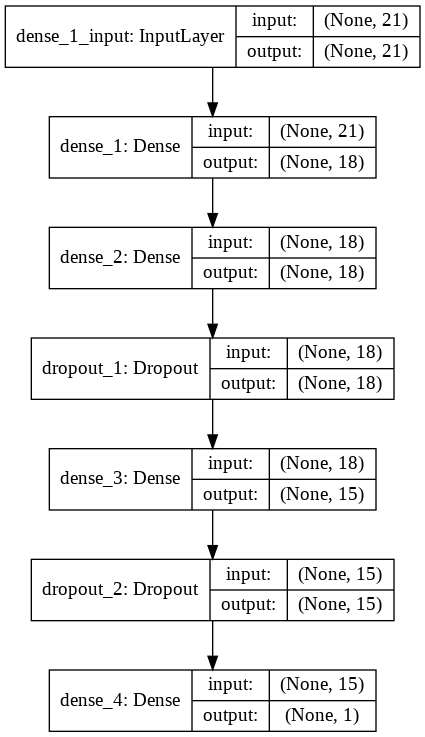

In [68]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [69]:
# defining compilation params
from keras.optimizers import RMSprop
#rmsprop = optimizers.RMSprop(learning_rate=0.001, rho=0.9)
model.compile(optimizer = RMSprop() , loss = 'mse', metrics = ['mse','mae'])


In [71]:
#Training the model
history = model.fit(X_train, y_train, batch_size = 128, nb_epoch = 50,validation_data = (X_test,y_test))

Train on 257382 samples, validate on 64346 samples
Epoch 1/50
 13952/257382 [>.............................] - ETA: 2s - loss: 0.2209 - mean_squared_error: 0.2209 - mean_absolute_error: 0.4127

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


257382/257382 [==============================] - 3s 12us/step - loss: 0.2181 - mean_squared_error: 0.2181 - mean_absolute_error: 0.4111 - val_loss: 0.2052 - val_mean_squared_error: 0.2052 - val_mean_absolute_error: 0.3970
Epoch 2/50
257382/257382 [==============================] - 3s 12us/step - loss: 0.2182 - mean_squared_error: 0.2182 - mean_absolute_error: 0.4111 - val_loss: 0.2078 - val_mean_squared_error: 0.2078 - val_mean_absolute_error: 0.3991
Epoch 3/50
257382/257382 [==============================] - 3s 12us/step - loss: 0.2179 - mean_squared_error: 0.2179 - mean_absolute_error: 0.4109 - val_loss: 0.2065 - val_mean_squared_error: 0.2065 - val_mean_absolute_error: 0.3973
Epoch 4/50
257382/257382 [==============================] - 3s 12us/step - loss: 0.2181 - mean_squared_error: 0.2181 - mean_absolute_error: 0.4111 - val_loss: 0.2072 - val_mean_squared_error: 0.2072 - val_mean_absolute_error: 0.3978
Epoch 5/50
257382/257382 [==============================] - 3s 12us/step - loss

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### **8.Prediction**

In [0]:
y_pred = model.predict(X_test)


In [75]:
r2 = r2_score(y_test,y_pred)
r2

0.7958743331555793

In [0]:
y_pred = pd.DataFrame(y_pred)

In [0]:
y_pred.to_csv('submit_lgb.csv',index=False)